Final Project Code:
(Very rough right now, will be cleaned up later)

Importing the data/setting up colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.pyplot import figure

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, RandomizedSearchCV, RepeatedStratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils.class_weight import compute_class_weight

import xgboost as xgb

## Google Drive File Location

In [59]:
import os

GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'CS3540/CS3540-FinalProject/'
GOOGLE_DRIVE_PATH = os.path.join('drive', 'MyDrive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(GOOGLE_DRIVE_PATH)
print(os.listdir(GOOGLE_DRIVE_PATH))

drive/MyDrive/CS3540/CS3540-FinalProject/
['fp_testbed.ipynb', 'kaggle_data', 'CS3540 Project Proposal Report.gdoc']


# Local File Location

In [76]:
import os
DATA_PATH = os.path.join(os.getcwd(), 'kaggle_data')
print(DATA_PATH)

g:\UVM\CS3540\_fp\kaggle_data


In [78]:
ddos_files = []

for dirname, _, filenames in os.walk(DATA_PATH):
    for filename in filenames:
        if filename.endswith('.parquet'):
            data_fp = os.path.join(dirname, filename)
            ddos_files.append(data_fp)
            print(data_fp)

# remove portmap data
ddos_files.remove(os.path.join(DATA_PATH, 'Portmap-training.parquet'))

g:\UVM\CS3540\_fp\kaggle_data\DNS-testing.parquet
g:\UVM\CS3540\_fp\kaggle_data\LDAP-testing.parquet
g:\UVM\CS3540\_fp\kaggle_data\LDAP-training.parquet
g:\UVM\CS3540\_fp\kaggle_data\MSSQL-testing.parquet
g:\UVM\CS3540\_fp\kaggle_data\MSSQL-training.parquet
g:\UVM\CS3540\_fp\kaggle_data\NetBIOS-testing.parquet
g:\UVM\CS3540\_fp\kaggle_data\NetBIOS-training.parquet
g:\UVM\CS3540\_fp\kaggle_data\NTP-testing.parquet
g:\UVM\CS3540\_fp\kaggle_data\Portmap-training.parquet
g:\UVM\CS3540\_fp\kaggle_data\SNMP-testing.parquet
g:\UVM\CS3540\_fp\kaggle_data\Syn-testing.parquet
g:\UVM\CS3540\_fp\kaggle_data\Syn-training.parquet
g:\UVM\CS3540\_fp\kaggle_data\TFTP-testing.parquet
g:\UVM\CS3540\_fp\kaggle_data\UDP-testing.parquet
g:\UVM\CS3540\_fp\kaggle_data\UDP-training.parquet
g:\UVM\CS3540\_fp\kaggle_data\UDPLag-testing.parquet
g:\UVM\CS3540\_fp\kaggle_data\UDPLag-training.parquet


In [7]:
ddos_df = pd.concat([pd.read_parquet(dfp) for dfp in ddos_files], ignore_index=True)

ddos_df.shape

(426266, 78)

In [8]:
print((ddos_df['Label'] == "MSSQL").sum())
print((ddos_df['Label'] == "DrDoS_MSSQL").sum())

8523
6212


In [9]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [10]:
ddos_df['Fwd Header Length'] = ddos_df['Fwd Header Length'].apply(lambda x: -1000 if x <= -10000 else x)
ddos_df['Fwd Seg Size Min'] = ddos_df['Fwd Seg Size Min'].apply(lambda x: -1000 if x <= -10000 else x)

ddos_df['Fwd Header Length'] = ddos_df['Fwd Header Length'].apply(lambda x: 1000 if x >= 10000 else x)
ddos_df['Fwd Seg Size Min'] = ddos_df['Fwd Seg Size Min'].apply(lambda x: 1000 if x >= 10000 else x)

count = (ddos_df['Fwd Header Length'] >= 1000).sum()
print(count)
count = (ddos_df['Fwd Seg Size Min'] >= 1000).sum()
print(count)
count = (ddos_df['Fwd Header Length'] <= -1000).sum()
print(count)
count = (ddos_df['Fwd Seg Size Min'] <= -1000).sum()
print(count)

46242
2825
9362
9362


In [11]:
print(ddos_df['Fwd Header Length'].min())
print(ddos_df['Fwd Seg Size Min'].min())
print(ddos_df['Fwd Header Length'].max())
print(ddos_df['Fwd Seg Size Min'].max())

-1000
-1000
9992
1480


In [9]:
ddos_df.head(10)

,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Fwd Packets Length Total,Bwd Packets Length Total,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Packet Length Min,Packet Length Max,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Avg Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Avg Bytes/Bulk,Fwd Avg Packets/Bulk,Fwd Avg Bulk Rate,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init Fwd Win Bytes,Init Bwd Win Bytes,Fwd Act Data Packets,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,17,48,2,0,2944.0,0.0,1472.0,1472.0,1472.0,0.0,0.0,0.0,0.0,0.0,6.133333e+07,4.166667e+04,48.0,0.0,48.0,48.0,48.0,48.0,0.0,48.0,48.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,4.166667e+04,0.0,1472.0,1472.0,1472.0,0.0,0.0,0,0,0,0,0,0,0,0,0.0,2208.0,1472.0,0.0,0,0,0,0,0,0,2,2944,0,0,-1,-1,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,DrDoS_DNS
1,17,2,2,0,2944.0,0.0,1472.0,1472.0,1472.0,0.0,0.0,0.0,0.0,0.0,1.472000e+09,1.000000e+06,2.0,0.0,2.0,2.0,2.0,2.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,-2,0,1.000000e+06,0.0,1472.0,1472.0,1472.0,0.0,0.0,0,0,0,0,0,0,0,0,0.0,2208.0,1472.0,0.0,0,0,0,0,0,0,2,2944,0,0,-1,-1,1,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,DrDoS_DNS
2,17,1,2,0,2944.0,0.0,1472.0,1472.0,1472.0,0.0,0.0,0.0,0.0,0.0,2.944000e+09,2.000000e+06,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,-2,0,2.000000e+06,0.0,1472.0,1472.0,1472.0,0.0,0.0,0,0,0,0,0,0,0,0,0.0,2208.0,1472.0,0.0,0,0,0,0,0,0,2,2944,0,0,-1,-1,1,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,DrDoS_DNS
3,17,1,2,0,2944.0,0.0,1472.0,1472.0,1472.0,0.0,0.0,0.0,0.0,0.0,2.944000e+09,2.000000e+06,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,2960,0,2.000000e+06,0.0,1472.0,1472.0,1472.0,0.0,0.0,0,0,0,0,0,0,0,0,0.0,2208.0,1472.0,0.0,0,0,0,0,0,0,2,2944,0,0,-1,-1,1,1480,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,DrDoS_DNS
4,17,1,2,0,2896.0,0.0,1448.0,1448.0,1448.0,0.0,0.0,0.0,0.0,0.0,2.896000e+09,2.000000e+06,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,2.000000e+06,0.0,1448.0,1448.0,1448.0,0.0,0.0,0,0,0,0,0,0,0,0,0.0,2172.0,1448.0,0.0,0,0,0,0,0,0,2,2896,0,0,-1,-1,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,DrDoS_DNS
5,17,1,2,0,2736.0,0.0,1368.0,1368.0,1368.0,0.0,0.0,0.0,0.0,0.0,2.736000e+09,2.000000e+06,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,2944,0,2.000000e+06,0.0,1368.0,1368.0,1368.0,0.0,0.0,0,0,0,0,0,0,0,0,0.0,2052.0,1368.0,0.0,0,0,0,0,0,0,2,2736,0,0,-1,-1,1,1472,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,DrDoS_DNS
6,17,1,2,0,2944.0,0.0,1472.0,1472.0,1472.0,0.0,0.0,0.0,0.0,0.0,2.944000e+09,2.000000e+06,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,28,0,2.000000e+06,0.0,1472.0,1472.0,1472.0,0.0,0.0,0,0,0,0,0,0,0,0,0.0,2208.0,1472.0,0.0,0,0,0,0,0,0,2,2944,0,0,-1,-1,1,14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,DrDoS_DNS
7,17,232,2,0,2944.0,0.0,1472.0,1472.0,1472.0,0.0,0.0,0.0,0.0,0.0,1.268966e+07,8.620690e+03,232.0,0.0,232.0,232.0,232.0,232.0,0.0,232.0,232.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,40,0,8.620689e+03,0.0,1472.0,1472.0,1472.0,0.0,0.0,0,0,0,0,0,0,0,0,0.0,2208.0,1472.0,0.0,0,0,0,0,0,0,2,2944,0,0,-1,-1,1,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,DrDoS_DNS
8,17,1,2,0,2896.0,0.0,1448.0,1448.0,1448.0,0.0,0.0,0.0,0.0,0.0,2.896000e+09,2.000000e+06,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,-2,0,2.0000

In [12]:
ddos_df['Label'] = ddos_df['Label'].replace('UDP-lag', 'UDPLag') # rename since they are the same thing

In [13]:
ddos_df['Label'].unique()

array(['DrDoS_DNS', 'Benign', 'DrDoS_LDAP', 'NetBIOS', 'LDAP',
       'DrDoS_MSSQL', 'MSSQL', 'DrDoS_NetBIOS', 'DrDoS_NTP', 'DrDoS_SNMP',
       'Syn', 'TFTP', 'DrDoS_UDP', 'UDP', 'UDPLag', 'WebDDoS'],
      dtype=object)

In [29]:
print(ddos_df['Label'].value_counts())

Label
4     121368
12     98917
0      93411
11     49373
13     18090
7      10420
14      8927
9       8523
3       6212
1       3669
6       2717
8       1906
2       1440
10       644
5        598
15        51
Name: count, dtype: int64


In [12]:
# Remove the 'DrDoS_' prefix from the test labels
# test_df['Label'] = test_df['Label'].str.replace(r'^DrDoS_', '', regex=True)
# test_df['Label'].unique()

In [14]:
mean = ddos_df['Fwd Header Length'].mean()
std = ddos_df['Fwd Header Length'].std()
print(mean, std)

300.06745787841396 744.8745614652435


### Features that are always zero

In [15]:
for col in ddos_df.columns:
    if ddos_df[col].sum() == 0:
        print(col)

Bwd PSH Flags
Fwd URG Flags
Bwd URG Flags
FIN Flag Count
PSH Flag Count
ECE Flag Count
Fwd Avg Bytes/Bulk
Fwd Avg Packets/Bulk
Fwd Avg Bulk Rate
Bwd Avg Bytes/Bulk
Bwd Avg Packets/Bulk
Bwd Avg Bulk Rate


In [16]:
drop_cols = {
    'Bwd PSH Flags',
    'Fwd URG Flags',
    'Bwd URG Flags',
    'FIN Flag Count',
    'PSH Flag Count',
    'ECE Flag Count',
    'Fwd Avg Bytes/Bulk',
    'Fwd Avg Packets/Bulk',
    'Fwd Avg Bulk Rate',
    'Bwd Avg Bytes/Bulk',
    'Bwd Avg Packets/Bulk',
    'Bwd Avg Bulk Rate'
}

In [17]:
for col in drop_cols:
    ddos_df.drop(col, axis=1, inplace=True)
ddos_df.shape

(426266, 66)

### Normalize Data and Encode Labels

In [18]:
def zscore_normalization(df, col_name):
    mean = df[col_name].mean()
    std = df[col_name].std()
    df[col_name] = (df[col_name] - mean) / std

    return df

In [19]:
cols = ddos_df.columns
cols = cols.drop('Label')
cols = cols.drop('Protocol') # Don't normalize the protocol value
for col in cols:
    ddos_df = zscore_normalization(ddos_df, col)

In [20]:
for col in cols:
    print(col, ddos_df[col].min(), ddos_df[col].max())

Flow Duration -0.3966821244680234 5.29941439605638
Total Fwd Packets -0.1197078929100513 445.36543476404967
Total Backward Packets -0.08012377917698182 275.3200219237306
Fwd Packets Length Total -0.27478957 440.41037
Bwd Packets Length Total -0.025065687 219.83862
Fwd Packet Length Max -1.1301954 99.81884
Fwd Packet Length Min -1.0889874 6.7059703
Fwd Packet Length Mean -1.2217786 10.010543
Fwd Packet Length Std -0.28492138 31.434855
Bwd Packet Length Max -0.1584767 77.72989
Bwd Packet Length Min -0.2670777 45.95525
Bwd Packet Length Mean -0.20263706 40.24108
Bwd Packet Length Std -0.16075425 55.285435
Flow Bytes/s -0.22270722137201307 8.588291479018764
Flow Packets/s -0.3053493885994181 9.368242872781074
Flow IAT Mean -0.50160396 31.38862
Flow IAT Std -0.5067526 23.8224
Flow IAT Max -0.41891238 13.06205
Flow IAT Min -0.018587904 236.85086
Fwd IAT Total -0.39338484 5.3048534
Fwd IAT Mean -0.4917753 25.15149
Fwd IAT Std -0.48719177 20.945461
Fwd IAT Max -0.41512588 13.090989
Fwd IAT Min

In [21]:
# Encode labels and separate features and target
label_encoder = LabelEncoder()
label_encoder.fit(ddos_df['Label'].unique())

ddos_df['Label'] = label_encoder.transform(ddos_df['Label'])

label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

for label, encoded_value in label_mapping.items():
    print(f"Label: {label} - Encoded Value: {encoded_value}")

Label: Benign - Encoded Value: 0
Label: DrDoS_DNS - Encoded Value: 1
Label: DrDoS_LDAP - Encoded Value: 2
Label: DrDoS_MSSQL - Encoded Value: 3
Label: DrDoS_NTP - Encoded Value: 4
Label: DrDoS_NetBIOS - Encoded Value: 5
Label: DrDoS_SNMP - Encoded Value: 6
Label: DrDoS_UDP - Encoded Value: 7
Label: LDAP - Encoded Value: 8
Label: MSSQL - Encoded Value: 9
Label: NetBIOS - Encoded Value: 10
Label: Syn - Encoded Value: 11
Label: TFTP - Encoded Value: 12
Label: UDP - Encoded Value: 13
Label: UDPLag - Encoded Value: 14
Label: WebDDoS - Encoded Value: 15


In [22]:
# Split features and labels
ddos_X = ddos_df.drop(columns=['Label'])
ddos_y = ddos_df['Label']
print(ddos_X.shape)
print(ddos_y.shape)

(426266, 65)
(426266,)


In [23]:
X_split, X_val, y_split, y_val = train_test_split(ddos_X, ddos_y, test_size=0.6, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_split, y_split, test_size=0.2, random_state=87)

In [24]:
print("Xval", X_val.shape)
print("yval", y_val.shape)
print("Xtrain", X_train.shape)
print("ytrain", y_train.shape)
print("Xtest", X_test.shape)
print("ytest", y_test.shape)
print(y_val.value_counts())
print(y_train.value_counts())
print(y_test.value_counts())

Xval (255760, 65)
yval (255760,)
Xtrain (136404, 65)
ytrain (136404,)
Xtest (34102, 65)
ytest (34102,)
Label
4     72735
12    59082
0     56226
11    29636
13    10916
7      6289
14     5424
9      5131
3      3696
1      2209
6      1635
8      1149
2       859
10      386
5       356
15       31
Name: count, dtype: int64
Label
4     38828
12    32011
0     29576
11    15857
13     5736
7      3325
14     2784
9      2750
3      2045
1      1163
6       848
8       616
2       456
10      208
5       187
15       14
Name: count, dtype: int64
Label
4     9805
12    7824
0     7609
11    3880
13    1438
7      806
14     719
9      642
3      471
1      297
6      234
8      141
2      125
5       55
10      50
15       6
Name: count, dtype: int64


# Random Forest

In [80]:
# Parameters for RF model
# These take way too long
# forest_params = {
    # 'n_estimators': [100, 200, 300, 400, 500], # arbitrary test values
    # 'max_depth': [None, 10, 20, 30, 40, 50], # arbitrary test values
    # 'criterion': ['gini', 'entropy'], # gini impurity and entropy version of shannon information gain
    # 'min_samples_split': [2, 5, 10, 15, 20], # arbitrary test values
    # 'min_samples_leaf': [1, 2, 4, 8, 16] # arbitrary test values
# }

In [25]:
forest_params = {
    'n_estimators': [100, 200],  # fewer values for estimators
    'max_depth': [None, 10, 20],  # limit max_depth options
    'criterion': ['gini', 'entropy'], # gini impurity and entropy version of shannon information gain
    'min_samples_split': [2, 7],  # reduce split options
    'min_samples_leaf': [1, 4]  # fewer leaf sizes
}

In [27]:
# using default values of n_splits=5, n_repeats=10
# random_state=42 allows reproducible results for testing purposes
rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=42)

rand_forest = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_distributions=forest_params,
    cv=rskf,
    n_iter=2,
    n_jobs=2)

In [30]:
rand_forest_model = rand_forest.fit(X_train, y_train)

In [31]:
rand_forest_pred = rand_forest_model.predict(X_test)
accuracy_score(y_test, rand_forest_pred)

0.9409712040349539

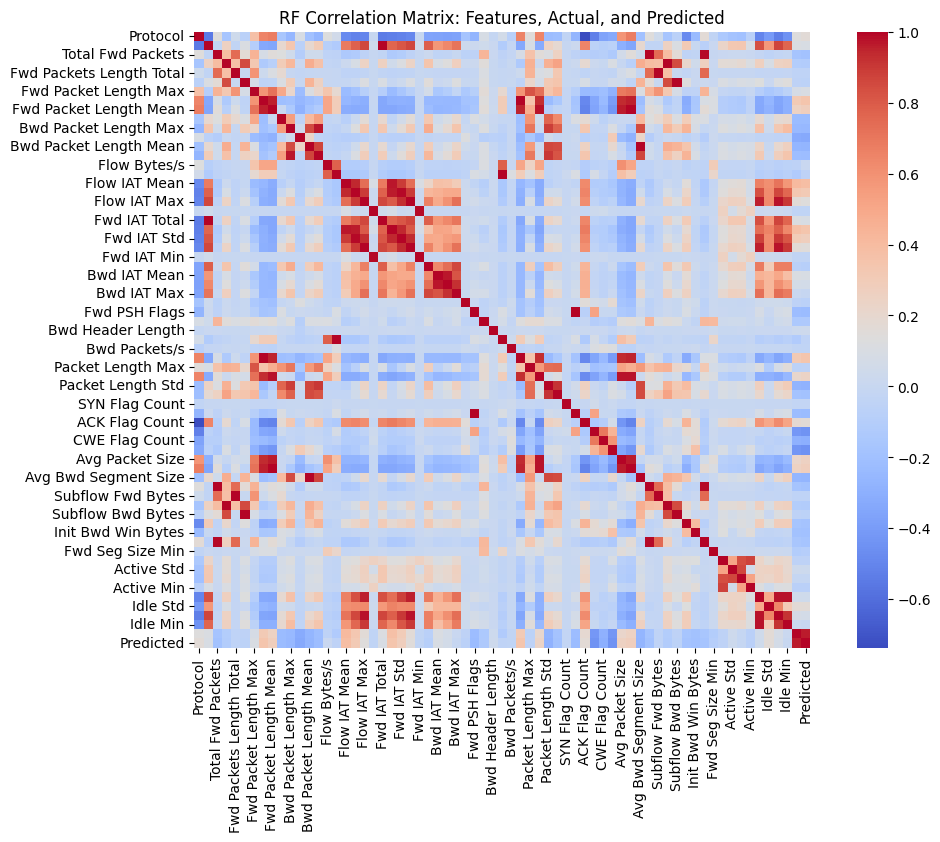

In [33]:
rf_comparison = pd.DataFrame(X_test, columns=ddos_X.columns)
rf_comparison['Actual'] = y_test
rf_comparison['Predicted'] = rand_forest_pred

correlation_matrix = rf_comparison.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt='.2f', cbar=True, square=True)
plt.title('RF Correlation Matrix: Features, Actual, and Predicted')
plt.show()

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      7609
           1       0.61      0.50      0.55       297
           2       0.50      0.08      0.14       125
           3       0.18      0.01      0.02       471
           4       1.00      1.00      1.00      9805
           5       0.00      0.00      0.00        55
           6       0.60      0.81      0.69       234
           7       0.56      0.15      0.23       806
           8       0.38      0.44      0.41       141
           9       0.52      0.95      0.67       642
          10       0.48      0.94      0.64        50
          11       1.00      0.99      0.99      3880
          12       1.00      1.00      1.00      7824
          13       0.61      0.92      0.74      1438
          14       0.94      0.76      0.84       719
          15       0.00      0.00      0.00         6

    accuracy                           0.94     34102
   

g:\UVM\CS3540\_fp\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
g:\UVM\CS3540\_fp\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
g:\UVM\CS3540\_fp\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


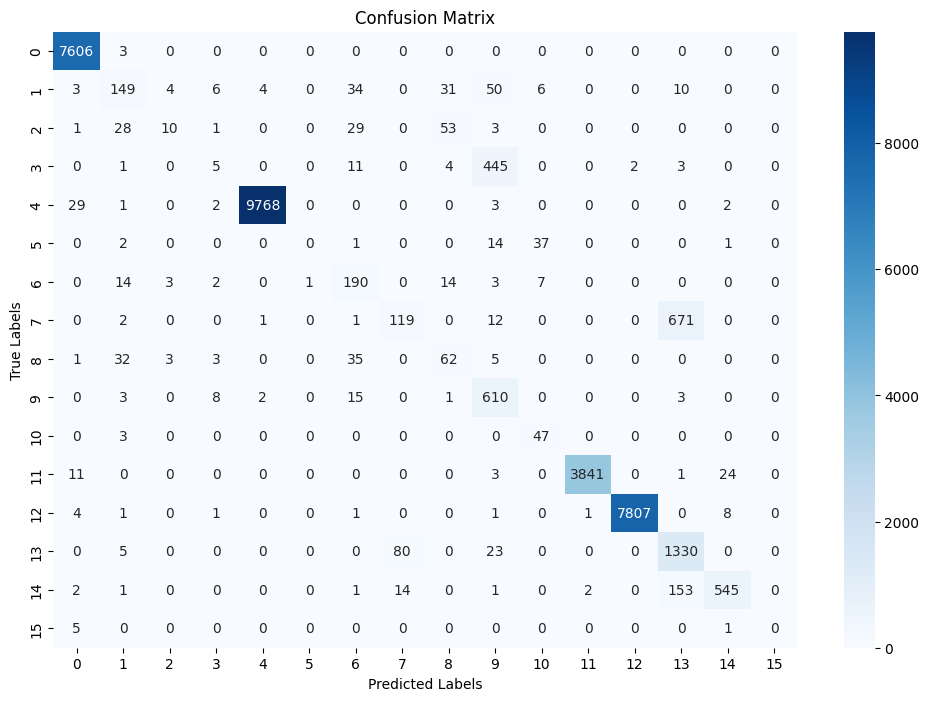

In [52]:
print("Classification Report:")
print(classification_report(y_test, rand_forest_pred))
print("Confusion Matrix:")
cm = confusion_matrix(y_test, rand_forest_pred)
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=rand_forest_model.classes_, yticklabels=rand_forest_model.classes_)

# Labels and title
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

## Feature Extraction

                     Feature  Importance
7      Fwd Packet Length Min    0.086348
35         Packet Length Min    0.080334
8     Fwd Packet Length Mean    0.068139
46           Avg Packet Size    0.066323
36         Packet Length Max    0.054941
47      Avg Fwd Segment Size    0.054579
37        Packet Length Mean    0.050707
6      Fwd Packet Length Max    0.047826
21              Fwd IAT Mean    0.042770
22               Fwd IAT Std    0.033508
14              Flow Bytes/s    0.031398
17              Flow IAT Std    0.031362
33             Fwd Packets/s    0.028271
16             Flow IAT Mean    0.028064
15            Flow Packets/s    0.027467
50         Subflow Fwd Bytes    0.026998
4   Fwd Packets Length Total    0.021636
42            ACK Flag Count    0.020028
20             Fwd IAT Total    0.018794
55      Fwd Act Data Packets    0.018490
2          Total Fwd Packets    0.014839
23               Fwd IAT Max    0.014543
53        Init Fwd Win Bytes    0.014171
18              

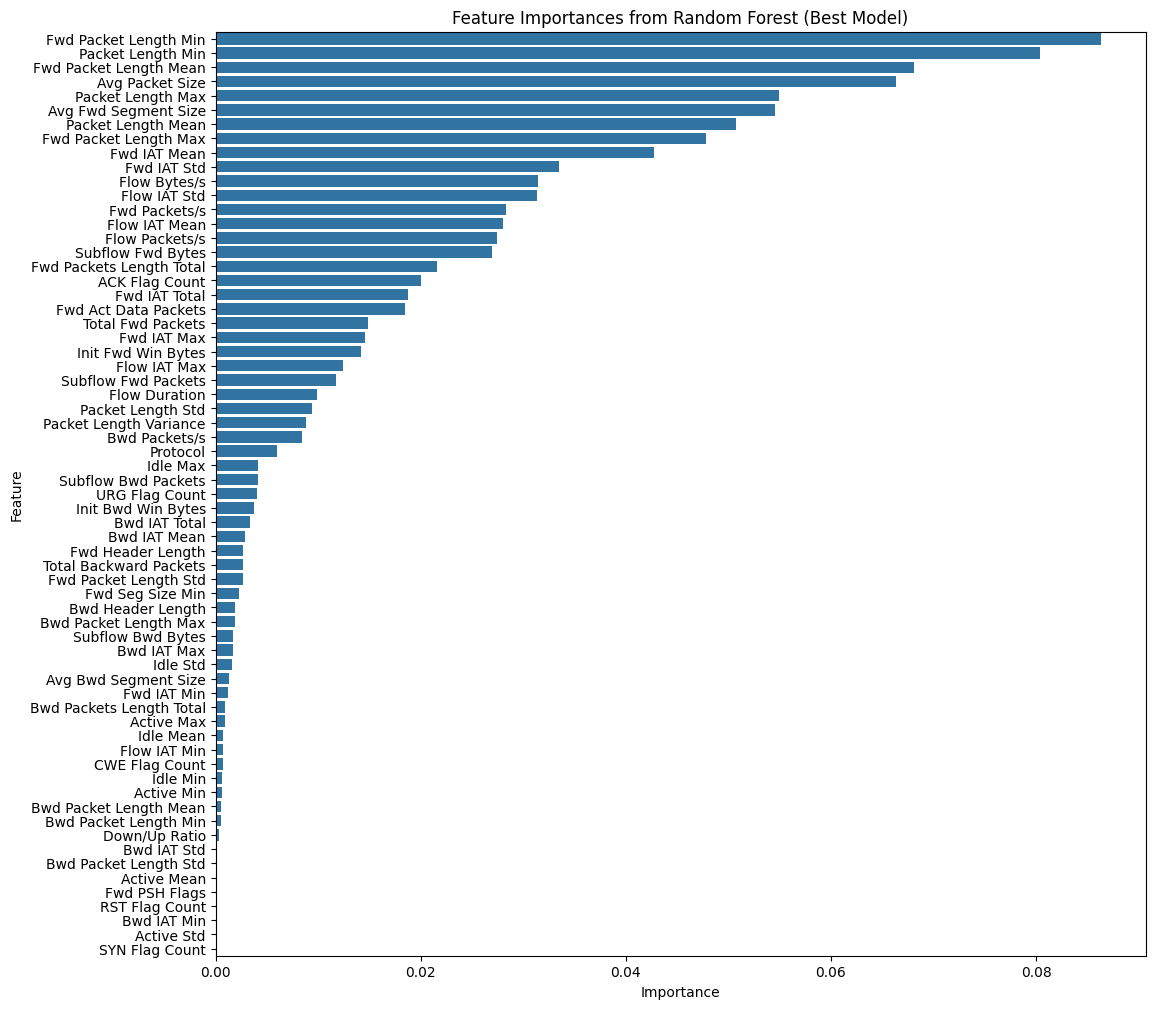

In [53]:
# Get the best model
best_rf = rand_forest_model.best_estimator_

# Extract the feature importances from the best model
feature_importances = best_rf.feature_importances_

# Create a DataFrame for feature importances
features = ddos_X.columns
feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
})

# Sort the features by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print the feature importance values
print(feature_importance_df)

# Plot the feature importances
plt.figure(figsize=(12, 12))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importances from Random Forest (Best Model)')
plt.show()

In [ ]:
low_val_feat = feature_importance_df[feature_importance_df['Importance'] < 0.01]['Feature']
for feature in low_val_feat:
    print(feature)
print(len(low_val_feat))

Flow Duration
Packet Length Std
Packet Length Variance
Bwd Packets/s
Protocol
Idle Max
Subflow Bwd Packets
URG Flag Count
Init Bwd Win Bytes
Bwd IAT Total
Bwd IAT Mean
Fwd Header Length
Total Backward Packets
Fwd Packet Length Std
Fwd Seg Size Min
Bwd Header Length
Bwd Packet Length Max
Subflow Bwd Bytes
Bwd IAT Max
Idle Std
Avg Bwd Segment Size
Fwd IAT Min
Bwd Packets Length Total
Active Max
Idle Mean
Flow IAT Min
CWE Flag Count
Idle Min
Active Min
Bwd Packet Length Mean
Bwd Packet Length Min
Down/Up Ratio
Bwd IAT Std
Bwd Packet Length Std
Active Mean
Fwd PSH Flags
RST Flag Count
Bwd IAT Min
Active Std
SYN Flag Count
40


In [49]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(136404, 25)
(34102, 25)
(255760, 25)


In [ ]:
for feature in low_val_feat:
    X_test.drop(feature, axis=1, inplace=True)
    X_train.drop(feature, axis=1, inplace=True)
    X_val.drop(feature, axis=1, inplace=True)

In [50]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)


(136404, 25)
(34102, 25)
(255760, 25)


## Random Forest With Reduced Dataset

In [54]:
rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=42)

rand_forest = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_distributions=forest_params,
    cv=rskf,
    n_iter=2,
    n_jobs=2)

In [55]:
rand_forest_model = rand_forest.fit(X_train, y_train)

In [56]:
rand_forest_pred = rand_forest_model.predict(X_test)
accuracy_score(y_test, rand_forest_pred)

0.9393583954020293

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      7609
           1       0.64      0.46      0.54       297
           2       0.40      0.16      0.23       125
           3       0.42      0.34      0.38       471
           4       1.00      1.00      1.00      9805
           5       0.40      0.18      0.25        55
           6       0.62      0.74      0.67       234
           7       0.43      0.09      0.15       806
           8       0.39      0.55      0.46       141
           9       0.54      0.69      0.60       642
          10       0.51      0.76      0.61        50
          11       1.00      0.99      1.00      3880
          12       1.00      1.00      1.00      7824
          13       0.60      0.92      0.72      1438
          14       0.93      0.76      0.83       719
          15       0.00      0.00      0.00         6

    accuracy                           0.94     34102
   

g:\UVM\CS3540\_fp\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
g:\UVM\CS3540\_fp\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
g:\UVM\CS3540\_fp\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


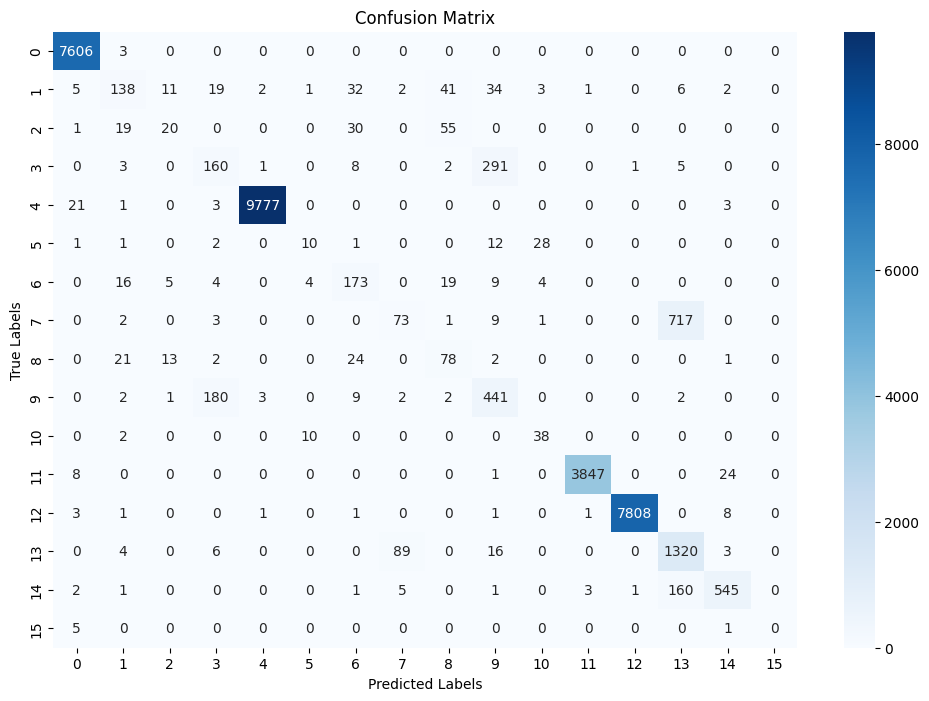

In [57]:
print("Classification Report:")
print(classification_report(y_test, rand_forest_pred))
print("Confusion Matrix:")
cm = confusion_matrix(y_test, rand_forest_pred)
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=rand_forest_model.classes_, yticklabels=rand_forest_model.classes_)

# Labels and title
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Random Forest with Reduced Dataset and Class Weights

In [60]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(zip(np.unique(y_train), class_weights))
for cl, w in class_weights_dict.items():
    print(f"Class: {cl} - Weight: {w}")

Class: 0 - Weight: 0.2882489180416554
Class: 1 - Weight: 7.330395528804815
Class: 2 - Weight: 18.695723684210527
Class: 3 - Weight: 4.1688264058679705
Class: 4 - Weight: 0.2195644895436283
Class: 5 - Weight: 45.589572192513366
Class: 6 - Weight: 10.053360849056604
Class: 7 - Weight: 2.563984962406015
Class: 8 - Weight: 13.839691558441558
Class: 9 - Weight: 3.100090909090909
Class: 10 - Weight: 40.98677884615385
Class: 11 - Weight: 0.5376332219209182
Class: 12 - Weight: 0.26632251413576585
Class: 13 - Weight: 1.486270920502092
Class: 14 - Weight: 3.062230603448276
Class: 15 - Weight: 608.9464285714286


In [62]:
forest_params = {
    'n_estimators': [100, 200],  # fewer values for estimators
    'max_depth': [None, 10, 20],  # limit max_depth options
    'criterion': ['gini', 'entropy'], # gini impurity and entropy version of shannon information gain
    'min_samples_split': [2, 7],  # reduce split options
    'min_samples_leaf': [1, 4],  # fewer leaf sizes
    'class_weight': [class_weights_dict]
}

rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=42)

rand_forest = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_distributions=forest_params,
    cv=rskf,
    n_iter=2,
    n_jobs=2)

In [63]:
rand_forest_model = rand_forest.fit(X_train, y_train)

In [64]:
rand_forest_pred = rand_forest_model.predict(X_test)
accuracy_score(y_test, rand_forest_pred)

0.9310011143041463

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7609
           1       0.56      0.43      0.49       297
           2       0.25      0.34      0.29       125
           3       0.43      0.46      0.45       471
           4       1.00      1.00      1.00      9805
           5       0.17      0.29      0.22        55
           6       0.69      0.64      0.67       234
           7       0.36      0.42      0.39       806
           8       0.37      0.57      0.45       141
           9       0.56      0.51      0.53       642
          10       0.51      0.76      0.61        50
          11       1.00      0.99      0.99      3880
          12       1.00      1.00      1.00      7824
          13       0.61      0.59      0.60      1438
          14       0.89      0.77      0.83       719
          15       0.00      0.00      0.00         6

    accuracy                           0.93     34102
   

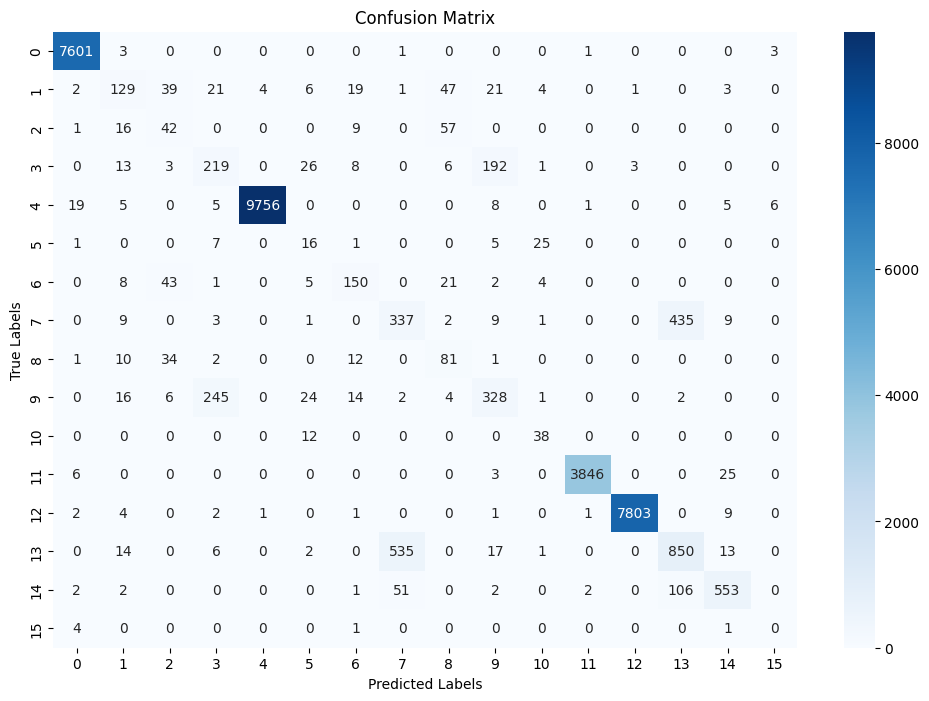

In [65]:
print("Classification Report:")
print(classification_report(y_test, rand_forest_pred))
print("Confusion Matrix:")
cm = confusion_matrix(y_test, rand_forest_pred)
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=rand_forest_model.classes_, yticklabels=rand_forest_model.classes_)

# Labels and title
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# XGBoost

In [79]:
X_split, X_val, y_split, y_val = train_test_split(ddos_X, ddos_y, test_size=0.6, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_split, y_split, test_size=0.2, random_state=87)
print("Xval", X_val.shape)
print("yval", y_val.shape)
print("Xtrain", X_train.shape)
print("ytrain", y_train.shape)
print("Xtest", X_test.shape)
print("ytest", y_test.shape)

Xval (255760, 65)
yval (255760,)
Xtrain (136404, 65)
ytrain (136404,)
Xtest (34102, 65)
ytest (34102,)


In [69]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [80]:
xgb_model = xgb.XGBClassifier(
    # objective = 'multi:softmax',
    # n_estimators = 100,
    # max_depth = 6,
    # learning_rate = 0.1,
    random_state = 42,
)

In [81]:
xgb_model.fit(X_train, y_train)

g:\UVM\CS3540\_fp\.venv\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The XGBClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


AttributeError: 'super' object has no attribute '__sklearn_tags__'

AttributeError: 'super' object has no attribute '__sklearn_tags__'

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [ ]:
y_pred = xgb_model.predict(X_test_scaled)

In [ ]:
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Optionally, you can plot the feature importances
xgb.plot_importance(xgb_model, importance_type='weight')
plt.show()